# Test final :)

In [1]:
import torch
from tqdm import tqdm

import sys
sys.path.append('../')
import Datasets
from models import *

import Metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
batch_size = 16
pretrainedModelURL = Wav2VecFineTune.PRETRAINED_VOXPOPULI

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cuda:0


In [ ]:
model = Wav2VecFineTune_Conv1D( pretrainedModelURL, freeze=False, dropoutProb=0.1 ).to(device)

In [ ]:
model.load_state_dict( torch.load("models/modelo-final-9.pt") )

## Testeo que de alto con el dataset de training

In [ ]:
datasetName, dfAudio, dfMetadata = Datasets.getQOMvsSPA( Datasets.DATASET_RAW )

In [ ]:
testset = Dataset(dfAudio, dfMetadata, wav2vec2ModelURL = pretrainedModelURL)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                        shuffle=False, num_workers=7,
                                        collate_fn=testset.collate_wrapper)

In [ ]:
with torch.no_grad():
    model.eval()
    test_epoch_loss = 0
    test_outputs = []
    test_true_labels = []
    for i, data in tqdm(enumerate(testloader, 0)):
        labels = data["labels"].to(device) 
        inputs = data["input_values"].to(device)
        masks = data["attention_mask"].to(device)

        outputs = model(inputs, masks)
#         loss = criterion(outputs, labels)

#         test_epoch_loss += loss.item()
        test_outputs.append(outputs.detach().cpu().numpy())
        test_true_labels.append(labels.detach().cpu().numpy())

#     test_epoch_loss /= len(testloader)
#     tensorboardWriter.add_scalar(f"Loss/test/{testFold}", test_epoch_loss, epoch)
    test_outputs = np.concatenate( test_outputs )
    test_true_labels = np.concatenate( test_true_labels )

    ##########
    # Metrics EER && AUC
    ##########

    y_test = test_true_labels
    y_test_pred = test_outputs
    time = 0

    metrics = Metrics.getMetricsPred(y_test, y_test_pred, withThreshold=True)
    print(metrics)
#     tensorboardWriter.add_scalar(f"EER/train/{testFold}", metrics["train"]["eer"], epoch)
#     tensorboardWriter.add_scalar(f"AUC/train/{testFold}", metrics["train"]["auc"], epoch)
#     tensorboardWriter.add_scalar(f"EER/test/{testFold}", metrics["test"]["eer"], epoch)
#     tensorboardWriter.add_scalar(f"AUC/test/{testFold}", metrics["test"]["auc"], epoch)

Con el train da que el threshold debería ser 0.69668055

## Predigo el posta

In [ ]:
import utils
from glob import glob

In [ ]:
pathNoTrain = "/home/leandro/Data/QOM/todo/wavNoTrainElegidos"
archivos = glob(f"{pathNoTrain}/*.wav")
len(archivos)

In [33]:
# dfAudio = utils.getAudioData( archivos, features = "raw" )
#np.save("audioNoTrainElegido", dfAudio )
dfAudio = np.load("audioNoTrainElegido.npy", allow_pickle=True)

In [ ]:
dfAudio.shape

In [ ]:
# datasetName, dfAudio, dfMetadata = Datasets.getQOMvsSPA( Datasets.DATASET_RAW )

### Check duraciones

In [34]:
duraciones = []
for r in dfAudio:
    duraciones.append(r.shape[0] / utils.SAMPLE_RATE)

In [ ]:
plt.hist(duraciones)

In [ ]:
for i, d in enumerate(duraciones):
    if d > 5:
        print(archivos[i], d)

### Ahora si

In [ ]:
# import imp
# import models
# imp.reload(models)

In [ ]:
testset = Dataset(dfAudio, wav2vec2ModelURL = pretrainedModelURL)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                        shuffle=False, num_workers=7,
                                        collate_fn=testset.collate_wrapper)

In [ ]:
with torch.no_grad():
    model.eval()
    test_epoch_loss = 0
    test_outputs = []
    test_true_labels = []
    for i, data in tqdm(enumerate(testloader, 0)):
#         labels = data["labels"].to(device) 
        inputs = data["input_values"].to(device)
        masks = data["attention_mask"].to(device)

        outputs = model(inputs, masks)
        test_outputs.append(outputs.detach().cpu().numpy())

    test_outputs = np.concatenate( test_outputs )

In [ ]:
#se podría usar 0.9 de threshold

In [4]:
# np.save("audioNoTrainResultados-9epochs", np.concatenate(test_outputs))
test_outputs = np.load("audioNoTrainResultados-9epochs.npy", allow_pickle=True)

In [5]:
test_outputs.shape

(72706,)

## Uso distintos thresholds para ver cuanto da

* 0 es spa
* 1 es qom

In [28]:
sns.set_style("white")
sns.set(font_scale = 1.2)

/home/leandro/apps/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/leandro/apps/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/leandro/apps/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


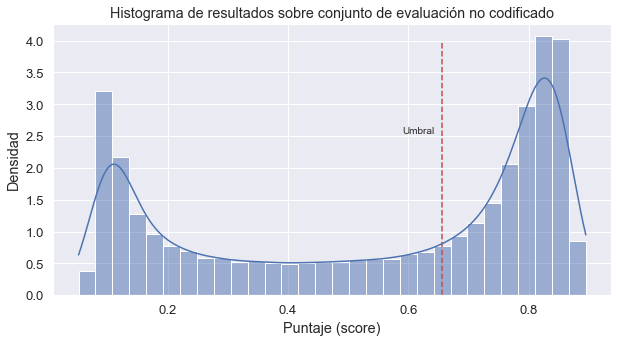

In [74]:
plt.figure( figsize=(10,5) )
sns.histplot(test_outputs, kde=True, stat="density")
plt.vlines(0.655,0,4,'r','dashed' )
plt.text(0.59,2.55,"Umbral", {"fontsize": 10})

plt.xlabel("Puntaje (score)")
plt.ylabel("Densidad")



title = "Histograma de resultados sobre conjunto de evaluación no codificado"
plt.title(title)
plt.savefig(f"plots/{title}.png", dpi=150)
# print(test_outputs.min())
# print(test_outputs.max())

In [35]:
print(len(duraciones))
print(len(test_outputs))

72706
72706


In [40]:
thresholds = {
    0.5 : {
        "spa" : 0,
        "qom" : 0
    },
    0.655 : {
        "spa" : 0,
        "qom" : 0
    },
    0.8 : {
        "spa" : 0,
        "qom" : 0
    },
    0.9 : {
        "spa" : 0,
        "qom" : 0
    }
}

for i, output in enumerate(test_outputs):
    for threshold in thresholds:
        if output > threshold:
            thresholds[threshold]["qom"] += duraciones[i]
        else:
            thresholds[threshold]["spa"] += duraciones[i]

for threshold in thresholds:
    thresholds[threshold]["qom"] = thresholds[threshold]["qom"]/60/60
    thresholds[threshold]["spa"] = thresholds[threshold]["spa"]/60/60

thresholds

{0.5: {'spa': 24.589193281249834, 'qom': 36.62450461805539},
 0.655: {'spa': 30.396691076388755, 'qom': 30.817006822916472},
 0.8: {'spa': 43.78420642361087, 'qom': 17.429491475694462},
 0.9: {'spa': 61.21369789930541, 'qom': 0.0}}

In [75]:
elegido = 0.655
total = thresholds[elegido]["spa"] + thresholds[elegido]["qom"]
print("spa", thresholds[elegido]["spa"]/total)
print("qom", thresholds[elegido]["qom"]/total)

spa 0.49656681624414256
qom 0.5034331837558574


In [76]:
extremos = {
    "spa" : 0,
    "qom" : 0
}
for i, output in enumerate(test_outputs):
    if output >= 0.7:
        extremos["qom"] += duraciones[i]
    if output <= 0.3:
        extremos["spa"] += duraciones[i]

extremos["spa"] = extremos["spa"]/60/60
extremos["qom"] = extremos["qom"]/60/60

extremos

{'spa': 18.227846545138764, 'qom': 28.341836249999744}

In [81]:
(extremos["qom"] + extremos["spa"]) / total

0.7607722518535687

In [78]:
extremos["qom"] / total

0.46299827036460445

In [79]:
total

61.21369789930523

## Prueba ROC

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
import numpy as np

In [ ]:
fooLabels = np.concatenate([np.repeat(0, len(test_outputs) // 2), np.repeat(1, len(test_outputs)//2)])

In [ ]:
fpr, tpr, threshold = roc_curve(fooLabels,test_outputs, pos_label=1)

In [ ]:
fpr.shape

In [ ]:
tpr.shape

In [ ]:
threshold

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.hist(threshold)